In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [2]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Input
from keras.layers import Embedding,LSTM,GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import Model



Using TensorFlow backend.


In [3]:
twit = pd.read_csv('train.csv')

In [4]:
twit.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
twit_df = twit.drop(columns = ['id','keyword','location'])

In [6]:
twit_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
pd.value_counts(twit_df['target'])

0    4342
1    3271
Name: target, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
print(len(nlp.Defaults.stop_words))
stopwords = (nlp.Defaults.stop_words)

326


In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S\s+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
    
def stop_words(text):
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

In [11]:
twit_df['text'] = twit_df['text'].apply(remove_URL)
twit_df['text'] = twit_df['text'].apply(remove_emoji)
twit_df['text'] = twit_df['text'].map(lambda x: remove_punct(x))
twit_df['text'] = twit_df['text'].map(lambda x: x.lower())
#twit_df['text'] = twit_df['text'].apply(stop_words)

twit_df['text'][0:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [12]:
X = twit_df['text']
y = twit_df['target']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.33,random_state = 42)

In [14]:
print(X_train.head())
print(X_train.shape)
print('\n\n')

print(y_train.head())

print('\n\n')

print(X_val.head())
print(X_val.shape)

print('\n\n')

print(y_val.head())

5836    photo postapocalypticflimflam prodding around ...
30                                                the end
1879                man crush everyday   cristianinspire 
6852    ptsdchat yes i feel the root of that is shame ...
2673    autoames everyone hoped we would join isis and...
Name: text, dtype: object
(5100,)



5836    0
30      0
1879    0
6852    1
2673    0
Name: target, dtype: int64



2644    so you have a new weapon that can cause unimag...
2227    the famping things i do for gishwhes just got ...
5448    dt georgegalloway rt gallowaymayor ûïthe col ...
132     aftershock back to school kick off was great i...
6845    in response to trauma children of addicts deve...
Name: text, dtype: object
(2513,)



2644    1
2227    0
5448    1
132     0
6845    0
Name: target, dtype: int64


In [15]:
from keras.preprocessing.text import Tokenizer

In [16]:
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [17]:
word2idx = tokenizer.word_index

print(X_train_seq[0])
v= len(word2idx)
v
#print(X_val_seq)

[249, 4991, 4992, 332, 1, 657]


13375

In [18]:
#standardize input length by padding and trucating

X_train_data = pad_sequences(X_train_seq)

T = X_train_data.shape[1]

X_val_data= pad_sequences(X_val_seq,maxlen=T)

In [19]:
T

31

In [20]:
print(X_val_data.shape)

(2513, 31)


In [26]:

D = 20
M=15


i = Input(shape=(T,))
x = Embedding(v+1,D)(i)
x = LSTM(M,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation = 'sigmoid')(x)

model = Model(i,x)



In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 31)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 31, 20)            267520    
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 15)            2160      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 269,696
Trainable params: 269,696
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
output_dir = 'model_output2/dense'

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [30]:
r = model.fit(X_train_data,y_train,epochs=10,verbose=0,
         callbacks=[modelcheckpoint])

C:\Users\cbatl\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyError: 'val_accuracy'

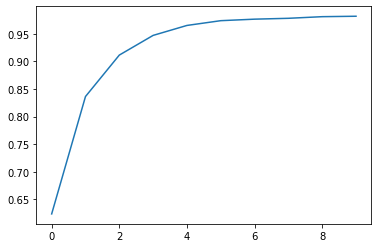

In [31]:
import matplotlib.pyplot as plt

plt.plot(r.history['accuracy'],label = 'Training_Accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_Accuracy')
plt.legend()

In [27]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [32]:
y_hat = model.predict(X_val_data)

In [35]:
#y_hat_classes = model.predict_classes(X_val_data)

y_hat_class = np.argmax(y_hat,axis=1)

In [39]:
y_hat_class

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
float_y_hat = []
for y in y_hat_class:
    float_y_hat.append(y[0])


IndexError: invalid index to scalar variable.

In [44]:
ydf = pd.DataFrame(list(zip(X_val,y_hat_class,y_val)),columns=['X_validation','y_hat','y_val'])

In [45]:
ydf

,X_validation,y_hat,y_val
0,so you have a new weapon that can cause unimag...,0,1
1,the famping things i do for gishwhes just got ...,0,0
2,dt georgegalloway rt gallowaymayor ûïthe col ...,0,1
3,aftershock back to school kick off was great i...,0,0
4,in response to trauma children of addicts deve...,0,0
...,...,...,...
2508,messeymetoo i feel attacked,0,0
2509,here im the uk there isnt a deluge of canadian...,0,1
2510,american casualties including ûò fatalities a...,0,1
2511,ee recalls power bar phone chargers after expl...,0,1


In [42]:
ydf['y_hat'].value_counts()

0    2513
Name: y_hat, dtype: int64

In [46]:
ydf.to_csv('validation output.csv')